In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from gpjax.kernels.base import AdditiveKernel


import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb



from typing import List, Union, Callable
from jaxtyping import Num, Float
from gpjax.typing import Array, ScalarFloat
from beartype.typing import Optional
from gpjax.base import Module, param_field,static_field
import cola
from cola.linalg.decompositions.decompositions import Cholesky
from jax import vmap
from scipy.stats import qmc

# custom bits
from gpjax.precip_gp import VerticalDataset, VerticalSmoother, ConjugatePrecipGP, ProblemInfo, SwitchKernelNegative, SwitchKernelPositive
from gpjax.variational_precip_gp import VariationalPrecipGP, thin_model, VariationalPrecipGPSample, init_kernels, init_smoother

from gpjax.normalizer import Normalizer
from gpjax.plotting import plot_data, plot_marginals, plot_interactions, plot_params, plot_component

from gpjax.optim_utils import optim_builder, zero_grads


2024-03-28 17:17:11.028716: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)

2"Anisotropy of sub-gridscale orography"

3"Standard deviation of sub-gridscale orography"

4"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [2]:
def prep_data(type=str):
    #load data
    # X2d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D]
    # X3d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
    # Xstatic_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
    # Y_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
    X2d_raw = jnp.array(jnp.load("../data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
    X3d_raw = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
    Xstatic_raw = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
    Y_raw = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]


    pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)
    # random shuffle
    X2d = jr.permutation(key, X2d_raw)
    X3d = jr.permutation(key, X3d_raw)
    Xstatic = jr.permutation(key, Xstatic_raw)
    Y = jr.permutation(key, Y_raw)

    # look at ERA5 rain
    Y = Y[:,0:1] 

    # just keep the "prognostic" 3d inputs that joe considered (for now)
    # RH, tehta_e^+, theta_e, theta_e^*
    names_3d =  ["Absolute temperature,","Relative Humidity", "Specific Humidity", "Geopotential Height", "Zonal Wind","Meridional Wind","Potential Temperature (theta)","Equivalent Potential Temperature (tehta_e)", "Equivalent Potential Temperature Saturation Deficit (theta_e+)", "Saturated Equivalent Potential Temperature (theta_e*)", "MSE-conserving Plume Buoyancy"]
    names_3d_short =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
    idx_3d = [1,4,5,6,7,8,9]
    # idx_3d = [1, 7, 8, 9]
    names_3d = [names_3d[i] for i in idx_3d]
    names_3d_short = [names_3d_short[i] for i in idx_3d]
    X3d = X3d[:,idx_3d,:]

    names_static = ["Land-sea Mask","Angle of sub-gridscale orography","Anisotropy of sub-gridscale orography","Stdev of sub-gridscale orography","Slope of sub-gridscale orography"]
    names_static_short = ["LSM","O_angle","O_anisotrophy","O_sd","O_slope"]
    idx_static = [0, 3]
    names_static = [names_static[i] for i in idx_static]
    names_static_short = [names_static_short[i] for i in idx_static]
    Xstatic = Xstatic[:,idx_static]
    lsm_threshold = 0.5
    # # also use his "normalisatopm" for sigma_o
    o_sd_idx = names_static.index("Stdev of sub-gridscale orography")
    lsm_idx = names_static.index("Land-sea Mask")
    # Xstatic = Xstatic.at[:, o_sd_idx].set(jnp.where(Xstatic[:,lsm_idx]<lsm_threshold, jnp.nanmean(1.0+jnp.log(1+Xstatic[:,o_sd_idx][Xstatic[:,lsm_idx]>lsm_threshold])), 1.0+jnp.log(1+Xstatic[:,o_sd_idx]))) # optimize lsm_threshold?
    Xstatic = Xstatic.at[:, o_sd_idx].set(jnp.log(Xstatic[:,o_sd_idx]+1.0))
    #map = lambda x: jnp.log((x+1e-5)/(1-x+1e-5))
    # Xstatic = Xstatic.at[:,lsm_idx].set(map(Xstatic[:,lsm_idx]))
    # lsm_threshold = map(lsm_threshold)




    # names_2d = ["Sea Surface temperature", "Sensible heat flux land","Sensible heat flux sea", "Latent heat flux land","Latent heat flux sea", "Vertically-integrated moisture convergence", "Column relative humidity"]
    # names_2d_short = ["T_surface","flux_s_land","flux_s_sea","flux_l_land","flux_l_sea","moisture","CRH"]
    names_2d = ["Sea Surface temperature", "Sensible heat flux", "Latent heat flux", "Vertically-integrated moisture convergence", "Column relative humidity"]
    names_2d_short = ["T_surface","flux_s","flux_l","moisture","CRH"]
    idx_2d = [1,2]
    names_2d = [names_2d[i] for i in idx_2d]
    names_2d_short = [names_2d_short[i] for i in idx_2d]
    X2d = X2d[:,idx_2d]
    #sea_surface_idx = names_2d.index("Sea Surface temperature")
    # sea_surface = jnp.where(Xstatic[:,lsm_idx]>lsm_threshold, jnp.nanmean(X2d[:,sea_surface_idx]), X2d[:, sea_surface_idx])
    # X2d = X2d.at[:,sea_surface_idx].set(sea_surface) # turn nans corresonping to land for sea surface to fixed value, they will be ignored by switch kernels anyway 
    flux_s_idx = names_2d.index("Sensible heat flux")
    flux_l_idx = names_2d.index("Latent heat flux")
    #X2d = X2d.at[:,flux_s_idx].set(jnp.log(X2d[:,flux_s_idx]+0.01 - jnp.min(X2d[:,flux_s_idx])) )
    # X2d = X2d.at[:,flux_l_idx].set(jnp.log(X2d[:,flux_l_idx]+1.0 - jnp.min(X2d[:,flux_l_idx])))

    #remove all pressure levels above 500 hPA
    lowest_idx =  11 #7
    print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
    X3d = X3d[:, :, lowest_idx:]
    pressure_levels = pressure[:,lowest_idx:]
    pressure_mean = jnp.mean(pressure_levels)
    pressure_std = jnp.std(pressure_levels)
    pressure_levels = (pressure_levels - pressure_mean) / pressure_std

    # remove any entries with nan
    X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
    X2d_nan_idx = jnp.isnan(X2d).any(axis=1) # ignore sea surface
    Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
    Y_nan_idx = jnp.isnan(Y).any(axis=1)
    any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
    no_nan = ~ any_nan
    print(f"Removed {any_nan.sum()} entries with nan")
    X2d = X2d[no_nan,:]
    X3d = X3d[no_nan,:,:]
    Xstatic = Xstatic[no_nan,:]
    Y = Y[no_nan,:]



    if type == "no rain":
        # remove no rain days
        print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
        X3d = X3d[Y[:,0]>0,:]
        X2d = X2d[Y[:,0]>0,:]
        Xstatic = Xstatic[Y[:,0]>0,:]
        Y = Y[Y[:,0]>0,:]
    elif type == "just rain":
        # convert output to binary 
        Y = jnp.where(Y>0, 1.0, 0.0)
    elif type == "all":
        pass   
    else:
        raise ValueError("type must be 'no rain' or 'just rain'")


    num_2d_variables= X2d.shape[1]
    num_3d_variables= X3d.shape[1]
    num_static_variables= Xstatic.shape[1]
    num_not_3d_variables = num_2d_variables + num_static_variables
    num_variables = num_2d_variables + num_3d_variables + num_static_variables
    print(f"using {num_static_variables} static variables")
    print(f"using {num_2d_variables} 2d variables")
    print(f"using {num_3d_variables} 3d variables")
    names = names_3d + names_2d + names_static
    names_short = names_3d_short + names_2d_short + names_static_short
    print(f"using variables with names {names_short}")

    problem_info = ProblemInfo(
        num_2d_variables = num_2d_variables,
        num_3d_variables = num_3d_variables,
        num_static_variables = num_static_variables,
        names_2d_short = names_2d_short,
        names_3d_short = names_3d_short,
        names_static_short = names_static_short,
        names_2d = names_2d,
        names_3d = names_3d,
        names =names,
        names_short = names_short,
        names_static = names_static,
        num_variables = num_variables,
        pressure_levels = pressure_levels,
        pressure_mean = pressure_mean,
        pressure_std = pressure_std,
        lsm_threshold = lsm_threshold,
    )

    D = VerticalDataset(
        X2d = X2d,
        X3d = X3d,
        Xstatic = Xstatic,
        y=Y,
        standardize=True,
        standardize_with_NF=False,
        problem_info=problem_info,
    )

    return D, problem_info
    

    


Removed all pressure levels below [50000.] hPa
Removed 28 entries with nan
using 2 static variables
using 2 2d variables
using 7 3d variables
using variables with names ['RH', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'flux_s', 'flux_l', 'LSM', 'O_sd']
Standardized X2d and Xstatic with max and min
 overall standardized X3d with max and min
no Y standarisation
[[0.00199694 0.9818214  0.00199698 0.84522635 0.80939046 0.00199688
  0.89327717 0.82928742 0.92782658 0.99603339 0.94524161 0.56695625
  0.90227822 0.98487138 0.94168008 0.99861671 0.37480763 0.99743215
  0.97821722 0.98364453 0.99931958 0.93055279 0.63547837 0.99781218
  0.99910593 0.4276217  0.99678534 0.96836749 0.99554249 0.95340829
  0.92014935 0.92122494 0.93530214 0.93632175 0.99195322 0.99476935
  0.99933217 0.97977938 0.80194863 0.50643919 0.99197786 0.96585815
  0.99870345 0.9921195  0.99522505 0.955519   0.99884872 0.943599
  0.99196948 0.99447956 0.99862796 0.97512408 0.99683123 0.92304313
  0.98

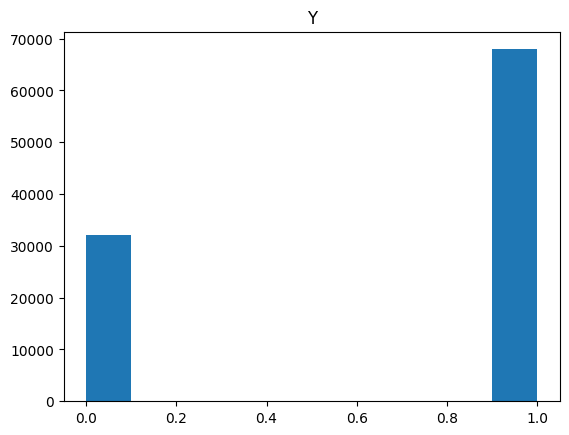

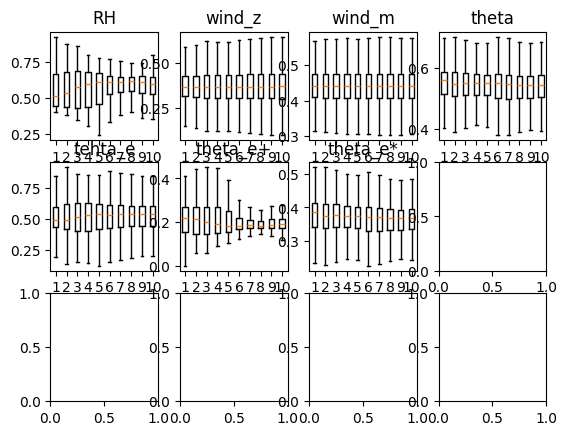

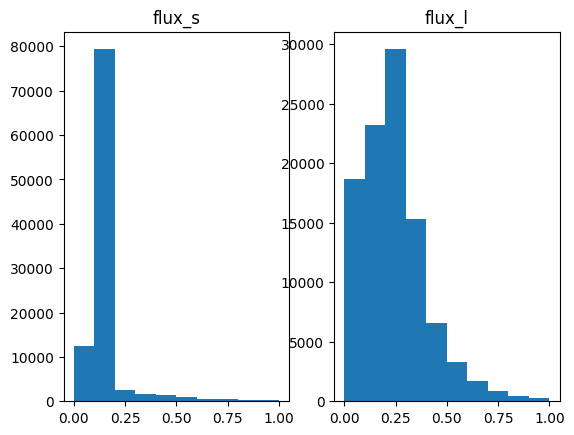

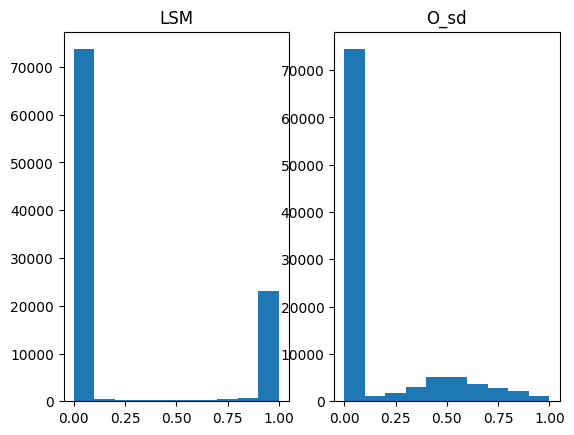

In [3]:

D, problem_info = prep_data("just rain")
plot_data(problem_info,D)


num_inducing=50
max_depth = 2
smoother = init_smoother(problem_info)


D_inducing = D.get_subset(500).get_subset(num_inducing, space_filling=True, no_3d=False, smoother=smoother)
inducing_inputs_3d = D_inducing.X3d
inducing_inputs_2d = D_inducing.X2d
inducing_inputs_static = D_inducing.Xstatic



D_ref = D_inducing#D.get_subset(250)








  0%|          | 0/500 [00:00<?, ?it/s]

interaction vars [[0.06168957 1.38467822 0.95071072]]


2024-03-28 17:18:04.354814: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.50GiB (rounded to 2679249664)requested by op 
2024-03-28 17:18:04.354952: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****_______________**************************************______________******************___________
2024-03-28 17:18:04.355020: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2679249600 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.50GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.50GiB
     preallocated temp allocation:    4.99GiB
  preallocated temp fragmentation:       128B (0.00%)
                 total allocation:    9.98GiB
              total fragmentation:    2.50GiB (25.00%)
Peak buffers:
	Buffer 1:
		Size: 2.50GiB
	

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2679249600 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.50GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.50GiB
     preallocated temp allocation:    4.99GiB
  preallocated temp fragmentation:       128B (0.00%)
                 total allocation:    9.98GiB
              total fragmentation:    2.50GiB (25.00%)
Peak buffers:
	Buffer 1:
		Size: 2.50GiB
		Operator: op_name="jit(solve)/jit(main)/vmap(jit(_lu_solve))/triangular_solve[left_side=True lower=False transpose_a=False conjugate_a=False unit_diagonal=False]" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=264
		XLA Label: custom-call
		Shape: f64[50,6698124]
		==========================

	Buffer 2:
		Size: 2.50GiB
		Operator: op_name="jit(solve)/jit(main)/vmap(jit(_lu_solve))/triangular_solve[left_side=True lower=True transpose_a=False conjugate_a=False unit_diagonal=True]" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=264
		XLA Label: custom-call
		Shape: f64[50,6698124]
		==========================

	Buffer 3:
		Size: 2.50GiB
		Entry Parameter Subshape: f64[67,1,50,99972]
		==========================

	Buffer 4:
		Size: 2.50GiB
		Operator: op_name="jit(solve)/jit(main)/vmap(jit(_lu_solve))/reshape[new_sizes=(50, 99972, 67) dimensions=None]" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=264
		XLA Label: fusion
		Shape: f64[67,50,99972]
		==========================

	Buffer 5:
		Size: 19.5KiB
		Operator: op_name="jit(solve)/jit(main)/lu" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=402
		XLA Label: fusion
		Shape: f64[1,50,50]
		==========================

	Buffer 6:
		Size: 19.5KiB
		Entry Parameter Subshape: f64[1,50,50]
		==========================

	Buffer 7:
		Size: 32B
		Operator: op_name="jit(solve)/jit(main)/lu" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=402
		XLA Label: custom-call
		Shape: (f64[1,50,50], s32[1,50], s32[1], f64[144])
		==========================

	Buffer 8:
		Size: 16B
		Operator: op_name="jit(solve)/jit(main)/vmap(jit(_lu_solve))/triangular_solve[left_side=True lower=False transpose_a=False conjugate_a=False unit_diagonal=False]" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=264
		XLA Label: custom-call
		Shape: (f64[50,6698124], s8[0])
		==========================

	Buffer 9:
		Size: 16B
		Operator: op_name="jit(solve)/jit(main)/vmap(jit(_lu_solve))/triangular_solve[left_side=True lower=True transpose_a=False conjugate_a=False unit_diagonal=True]" source_file="/home/henry/Documents/python_dev/GPJax/gpjax/variational_precip_gp.py" source_line=264
		XLA Label: custom-call
		Shape: (f64[50,6698124], s8[0])
		==========================



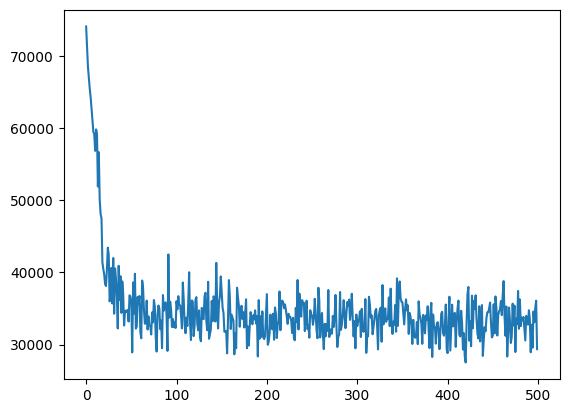

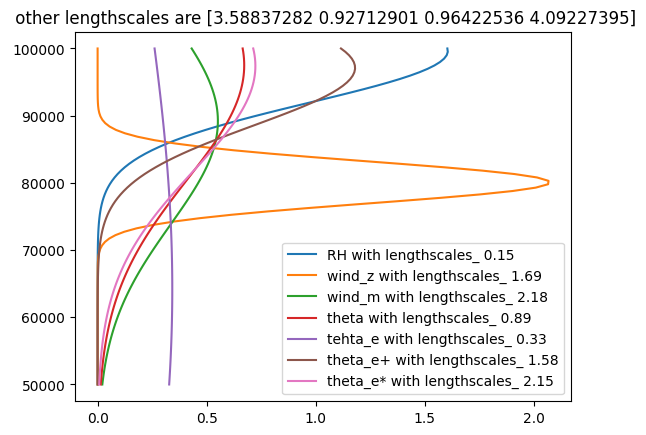

In [4]:



interaction_variance_init = jnp.array([[0.1,0.1,0.1]], dtype=jnp.float64)

max_depth = 2
bernoulli_posterior = VariationalPrecipGP(
    list_of_list_of_base_kernels=[init_kernels(problem_info)], 
    likelihood=gpx.likelihoods.Bernoulli(num_datapoints=D.n),
    smoother=smoother,
    variational_mean= jnp.zeros((1, num_inducing, 1)),
    variational_root_covariance= jnp.eye(num_inducing)[None,:,:],
    num_latents=1,
    max_interaction_depth=max_depth,
    interaction_variances=interaction_variance_init,
    jitter=jnp.array(1e-5, dtype=jnp.float64),
    measure = "empirical",
    inducing_inputs_3d=inducing_inputs_3d,
    inducing_inputs_2d=inducing_inputs_2d,
    inducing_inputs_static=inducing_inputs_static,
    parameterisation="white",
    fiddled_ng=False,
    lengthscale_penalisation_factor=1.0,
    ).replace_bijector(
    inducing_inputs_3d = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    inducing_inputs_2d = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    inducing_inputs_static = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    #variational_mean = tfb.Softplus(),
    D_ref = D_ref,
    #variational_root_covariance = tfb.Chain([tfb.FillTriangular(), tfb.SoftClip(low=jnp.array(-1e3, dtype=jnp.float64),high=jnp.array(1e3, dtype=jnp.float64))]),
).replace_trainable(
    inducing_inputs_3d=False, 
    inducing_inputs_2d=False, 
    inducing_inputs_static=False)


opt_bernoulli_posterior, history = gpx.fit(
        model=bernoulli_posterior,
        objective=jax.jit(bernoulli_posterior.loss_fn(negative=True)), #todo rejit
        train_data=D,
        optim=ox.adamw(1e-1),
        num_iters=500,
        batch_size=512,
        safe=False,
        key=key,
    )
plt.figure()
plt.plot(history)
plot_params(problem_info, opt_bernoulli_posterior,D)
print(f"interaction vars {opt_bernoulli_posterior.interaction_variances}")
#plot_interactions(problem_info, opt_bernoulli_posterior, D, k=5, use_range=False, use_inducing_points=True, use_ref=False)

In [ ]:
D, problem_info = prep_data("all")
D_thinning =  D.get_subset(1000)


initial_scale = jnp.mean(D.y[D.y>0])

bernoulli_gamma1_posterior = VariationalPrecipGP(
    list_of_list_of_base_kernels=[opt_bernoulli_posterior.list_of_list_of_base_kernels[0], init_kernels(problem_info)], 
    likelihood=gpx.likelihoods.BernoulliGamma(num_datapoints=D.n, initial_scale=initial_scale),
    smoother=opt_bernoulli_posterior.smoother,
    variational_mean= jnp.stack([opt_bernoulli_posterior.variational_mean[0], jnp.zeros((num_inducing, 1))]),
    variational_root_covariance= jnp.stack([opt_bernoulli_posterior.variational_root_covariance[0],jnp.eye(num_inducing)]),
    num_latents=2,
    max_interaction_depth=opt_bernoulli_posterior.max_interaction_depth,
    interaction_variances=jnp.stack([opt_bernoulli_posterior.interaction_variances[0],interaction_variance_init[0]]),
    jitter=opt_bernoulli_posterior.jitter,
    measure = opt_bernoulli_posterior.measure,
    inducing_inputs_3d=opt_bernoulli_posterior.inducing_inputs_3d,
    inducing_inputs_2d=opt_bernoulli_posterior.inducing_inputs_2d,
    inducing_inputs_static=opt_bernoulli_posterior.inducing_inputs_static,
    parameterisation=opt_bernoulli_posterior.parameterisation,
    D_ref = opt_bernoulli_posterior.D_ref,
    fiddled_ng=opt_bernoulli_posterior.fiddled_ng,
    lengthscale_penalisation_factor=opt_bernoulli_posterior.lengthscale_penalisation_factor,
    ).replace_bijector(
    inducing_inputs_3d = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    inducing_inputs_2d = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    inducing_inputs_static = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    #variational_mean = tfb.Softplus(),
    #variational_root_covariance = tfb.Chain([tfb.FillTriangular(), tfb.SoftClip(low=jnp.array(-1e3, dtype=jnp.float64),high=jnp.array(1e3, dtype=jnp.float64))]),
).replace_trainable(
    interaction_variances=True,
    inducing_inputs_3d=False, 
    inducing_inputs_2d=False, 
    inducing_inputs_static=False)




opt_bernoulli_gamma1_posterior, history = gpx.fit(
        model=bernoulli_gamma1_posterior,
        objective=jax.jit(bernoulli_gamma1_posterior.loss_fn(negative=True)), #todo rejit
        train_data=D,
        optim=ox.adamw(1e-1),
        num_iters=200,
        batch_size=512,
        safe=False,
        key=key,
    )
plt.plot(history)
plot_params(problem_info, opt_bernoulli_gamma1_posterior,D)
print(f"interaction vars {opt_bernoulli_gamma1_posterior.interaction_variances}")
# plot_interactions(problem_info, opt_bernoulli_gamma1_posterior, D, k=5, use_inducing_points=False, use_ref=True)

In [ ]:

bernoulli_gamma2_posterior = VariationalPrecipGP(
    list_of_list_of_base_kernels=[opt_bernoulli_gamma1_posterior.list_of_list_of_base_kernels[0], opt_bernoulli_gamma1_posterior.list_of_list_of_base_kernels[1],init_kernels(problem_info)], 
    likelihood=gpx.likelihoods.BernoulliGamma2(num_datapoints=D.n, initial_scale=opt_bernoulli_gamma1_posterior.likelihood.initial_scale),
    smoother=opt_bernoulli_gamma1_posterior.smoother,
    variational_mean= jnp.stack([opt_bernoulli_gamma1_posterior.variational_mean[0], opt_bernoulli_gamma1_posterior.variational_mean[1], jnp.zeros((num_inducing, 1))]),
    variational_root_covariance= jnp.stack([opt_bernoulli_gamma1_posterior.variational_root_covariance[0],opt_bernoulli_gamma1_posterior.variational_root_covariance[1],jnp.eye(num_inducing)]),
    num_latents=2,
    max_interaction_depth=opt_bernoulli_gamma1_posterior.max_interaction_depth,
    interaction_variances=jnp.stack([opt_bernoulli_gamma1_posterior.interaction_variances[0],opt_bernoulli_gamma1_posterior.interaction_variances[1],interaction_variance_init[0]]),
    jitter=opt_bernoulli_gamma1_posterior.jitter,
    measure = opt_bernoulli_gamma1_posterior.measure,
    inducing_inputs_3d=opt_bernoulli_gamma1_posterior.inducing_inputs_3d,
    inducing_inputs_2d=opt_bernoulli_gamma1_posterior.inducing_inputs_2d,
    inducing_inputs_static=opt_bernoulli_gamma1_posterior.inducing_inputs_static,
    parameterisation=opt_bernoulli_gamma1_posterior.parameterisation,
    D_ref = opt_bernoulli_gamma1_posterior.D_ref,
    fiddled_ng=opt_bernoulli_gamma1_posterior.fiddled_ng,
    lengthscale_penalisation_factor=opt_bernoulli_gamma1_posterior.lengthscale_penalisation_factor,
    ).replace_bijector(
    inducing_inputs_3d = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    inducing_inputs_2d = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    inducing_inputs_static = tfb.SoftClip(low=jnp.array(-1e-2, dtype=jnp.float64),high=jnp.array(1.0+1e-2, dtype=jnp.float64)),
    #variational_mean = tfb.Softplus(),
    #variational_root_covariance = tfb.Chain([tfb.FillTriangular(), tfb.SoftClip(low=jnp.array(-1e3, dtype=jnp.float64),high=jnp.array(1e3, dtype=jnp.float64))]),
).replace_trainable(
    interaction_variances=True,
    inducing_inputs_3d=False, 
    inducing_inputs_2d=False, 
    inducing_inputs_static=False)




opt_bernoulli_gamma2_posterior, history = gpx.fit(
        model=bernoulli_gamma2_posterior,
        objective=jax.jit(bernoulli_gamma2_posterior.loss_fn(negative=True)), #todo rejit
        train_data=D,
        optim=ox.adamw(1e-1),
        num_iters=200,
        batch_size=512,
        safe=False,
        key=key,
    )
plt.plot(history)
plot_params(problem_info, opt_bernoulli_gamma2_posterior,D)
print(f"interaction vars {opt_bernoulli_gamma2_posterior.interaction_variances}")
# plot_interactions(problem_info, opt_bernoulli_gamma2_posterior, D, k=5, use_inducing_points=False, use_ref=True)

In [ ]:
thinned_model = thin_model(problem_info, D_inducing, opt_bernoulli_gamma2_posterior, 5)
plot_params(problem_info, thinned_model,D)
print(f"interaction vars {thinned_model.interaction_variances}")
plot_interactions(problem_info, thinned_model,D, k=5, use_inducing_points=True, use_ref=False)
#gp_sample = VariationalPrecipGPSample(thinned_model, key=key)
# idx = 0
# num_samples=2
# z=thinned_model.smoother.smooth_data(D_thinning)[0]
# f = gp_sample.predict(z,[idx], num_samples=num_samples)
# for i in range(num_samples):    
#     plt.scatter(z[:,idx], f[0,:,i],s=0.1)


In [ ]:
def plot_samples(idx, latent, num_samples=5):
    plt.figure()
    gp_sample = VariationalPrecipGPSample(thinned_model, key=key)
    num_samples=5
    z=thinned_model.smoother.smooth_data(D_thinning)[0]
    f = gp_sample.predict(z,[idx], num_samples=num_samples)
    for i in range(num_samples):    
        plt.scatter(z[:,idx], f[latent,:,i],s=0.5)
    x = thinned_model.smoother.smooth_data(D_inducing)[0]
    f_x = gp_sample.predict(x,[idx], num_samples=num_samples)[latent]
    plt.scatter(x[:,idx:idx+1],jnp.zeros_like(x[:,idx:idx+1]))
    plt.xlim(jnp.min(x[:,idx:idx+1]),jnp.max(x[:,idx:idx+1]))
    plt.ylim(jnp.min(f_x), jnp.max(f_x))
    
    
    


In [ ]:
plt.hist(thinned_model.smoother.smooth_data(D)[0][:,0])